# Simple regression with product of normals

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

### About

I am trying to understand the underfitting in the VEB implementation of multiple regression with product of normals. Here, I will numerically check the underlying distributions for the special case of simple regression model.

In [1]:
#collapse-show

import numpy as np
import pandas as pd
from scipy import linalg as sc_linalg
from scipy import special as sc_special
from scipy import integrate as sc_integrate
import matplotlib.pyplot as plt

import mpl_stylesheet
import mpl_utils
from matplotlib import cm
from matplotlib import ticker as plticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

In [2]:
# collapse-hide

def variance_explained(y, ypred):
    ss_err = np.sum(np.square(y - ypred))
    ss_tot = np.sum(np.square(y - np.mean(y)))
    r2 = 1 - (ss_err / ss_tot)
    return r2

def prod_norm_prior_pdf(z, s1, s2):
    x = np.abs(z) / s1 / s2
    prob = sc_special.kn(0, x) / (np.pi * s1 * s2)
    return prob

def normal_logdensity_onesample(z, m, s2):
    logdensity = - 0.5 * np.log(2 * np.pi * s2) \
                 - 0.5 * (z - m) * (z - m) / s2
    return logdensity

def prod_norm_prior2_pdf(z, s1, s2):
    w = 3.5
    b = z / w
    p1 = np.exp(normal_logdensity_onesample(b, 0, s1 * s1))
    p2 = np.exp(normal_logdensity_onesample(w, 0, s2 * s2))
    return p1 * p2

def normal_logdensity(y, mean, sigma2):
    n = y.shape[0]
    logdensity = - 0.5 * n * np.log(2 * np.pi * sigma2) \
                 - 0.5 * np.sum(np.square(y - mean)) / sigma2
    return logdensity

def data_log_likelihood(X, y, b, sigma):
    ll = np.zeros_like(b)
    for i, _b in enumerate(b):
        ll[i] = normal_logdensity(y, X * _b, sigma * sigma)
    return ll

def normalize_by_grid(y, x):
    unnorm_sum = sc_integrate.simps(y, x)
    return y / unnorm_sum


def normalize_logdensity_by_grid(lny, x):
    y = np.exp(lny)
    M = sc_integrate.simps(y, x)
    return lny - np.log(M)

'''
Implement a simple Gibbs sampling algorithm to calculate the posterior distribution
'''

def sample_b(xtx, xty, w, sigma2, sigmab2):
    sb2inv = (1 / sigmab2) + (xtx * w * w / sigma2)
    sb2 = 1 / sb2inv
    mean = w * xty * sb2 / sigma2
    return np.random.normal(mean, np.sqrt(sb2))

def gibbs(X, y, sigma, sigmab, sigmaw,
          binit = 1.0, winit = 1.0,
          burn_iter = 1000,
          max_iter = 1000):
    
    xtx = np.sum(np.square(X))
    xty = np.dot(X, y)
    sigma2 = sigma * sigma
    sigmab2 = sigmab * sigmab
    sigmaw2 = sigmaw * sigmaw
    _b = binit
    _w = winit
    
    trace = np.zeros((max_iter, 2)) # trace to store values of b and w
    bwvals = np.zeros(max_iter)
    
    for itn in range(burn_iter):
        _b = sample_b(xtx, xty, _w, sigma2, sigmab2)
        _w = sample_b(xtx, xty, _b, sigma2, sigmaw2)
    for itn in range(max_iter):
        _b = sample_b(xtx, xty, _w, sigma2, sigmab2)
        _w = sample_b(xtx, xty, _b, sigma2, sigmaw2)
        trace[itn, :] = np.array([_b, _w])
        bwvals[itn] = _b * _w
        
    return trace, bwvals

### Toy model

I defined a toy model with one predictor (or independent variable) and 200 samples. I sampled the predictor from the standard normal distribution $\mathcal{N}(0, 1)$. The model used is described in the Appendix A of the [writeup](https://www.overleaf.com/read/zhcmmtmhbvgk). In short, the likelihood of the model is,

$\displaystyle p\left( y \mid x, b, w, \sigma^2 \right) = \prod_{n = 1}^{N} \mathcal{N} \left(y_n \mid x_n b w, \sigma^2 \right)$

We used normal priors with zero means for $b \sim \mathcal{N}(0, \sigma_b^2)$ and $w \sim \mathcal{N}(0, \sigma_w^2)$, which gives a prior probability of $bw$ as,

$\displaystyle p\left(bw \mid \sigma_b^2, \sigma_w^2\right) = \frac{K_0{\displaystyle \left(\frac{\lvert bw \rvert}{\sigma_b \sigma_w}\right)}}{\pi \sigma_b \sigma_w}$.

I chose $\sigma = 5.0$, $\sigma_b = 2.0$ and $\sigma_w = 4.0$. Let the true values for $b$ and $w$ be denoted as $\hat{b}$ and $\hat{w}$. The sum of the log prior and the log likelihood is proportional to the log posterior of $bw$. I called this the "numerical" posterior. The posterior is normalized using a discrete grid of $bw$. The prior, likelihood and posterior depends on the product $bw$ and hence will have the same densities along the line $b = 1 / w$.

I can also use Gibbs sampling technique to obtain the posterior distribution, and is labeled as 'Gibbs'. 

In [49]:
#collapse-hide

nsample = 10
sigbtrue = 2.0
sigwtrue = 4.0
sigtrue = 10.0
np.random.seed(200)
btrue = np.random.normal(0, sigbtrue)
wtrue = np.random.normal(0, sigwtrue)
bwtrue = btrue * wtrue
X = np.random.normal(0, 1, nsample)
y = X * btrue * wtrue + np.random.normal(0, sigtrue, nsample)
r2 = variance_explained(y, X * btrue * wtrue)
bwprior = np.multiply(np.random.normal(0, sigbtrue, 1000),
                      np.random.normal(0, sigwtrue, 1000))
mcmc_trace, mcmc_posterior = gibbs(X, y, sigtrue, sigbtrue, sigwtrue,
                                   burn_iter = 1000, max_iter = 10000)

print(f"Fraction of variance explained by X: {r2:.2f}")

Fraction of variance explained by X: 0.41


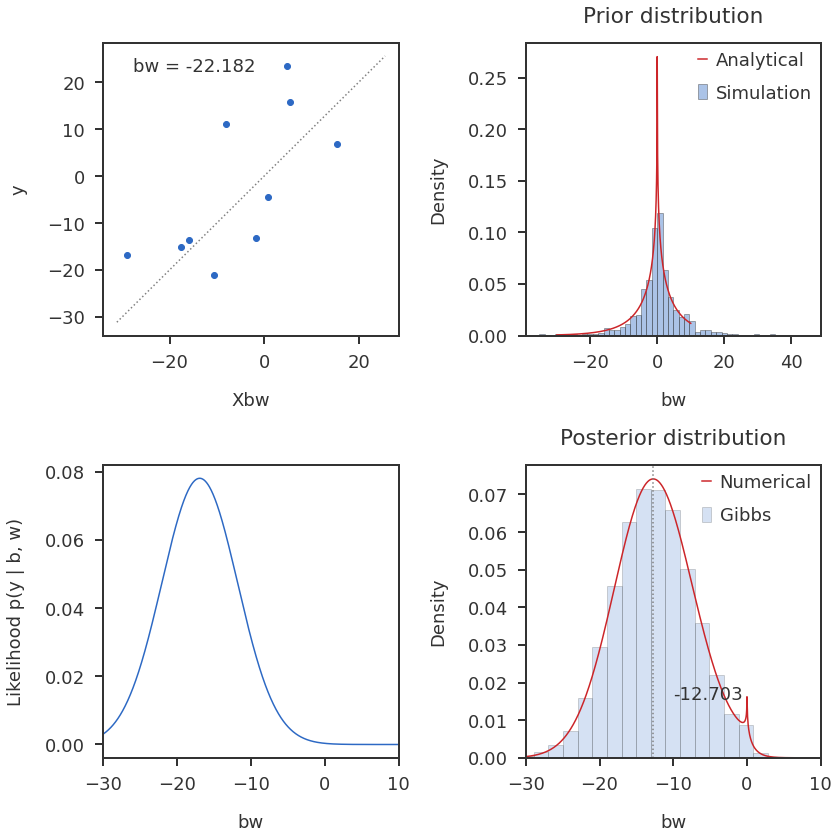

In [50]:
#collapse-hide

#bwvals = mpl_utils.x_linspace(ax2, n = 1000)
#bwvals = np.linspace(-40, 40, 1000)
bwvals = np.linspace(-30, 10, 1000)
xlims = [-30, 10]

numerical_prior = prod_norm_prior_pdf(bwvals, sigbtrue, sigwtrue)
numerical_logll = data_log_likelihood(X, y, bwvals, sigtrue)
numerical_likelihood = normalize_by_grid(np.exp(numerical_logll), bwvals)
numerical_logpost_unnorm = np.log(numerical_prior) + numerical_logll
numerical_logpost = normalize_logdensity_by_grid(numerical_logpost_unnorm, bwvals)
numerical_posterior = np.exp(numerical_logpost)
numerical_bwopt = bwvals[np.argmax(numerical_posterior)]


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(X * bwtrue, y)
mpl_utils.plot_diag(ax1)
ax1.text(0.1, 0.9, f"bw = {bwtrue:.3f}", transform = ax1.transAxes)
#ax1.set_title("y = Xbw + e", pad = 20.0)
ax1.set_xlabel("Xbw")
ax1.set_ylabel("y")

ax2.hist(bwprior, bins = 50, density = True, alpha = 0.4, label="Simulation")
ax2.plot(bwvals, numerical_prior, label = "Analytical")
ax2.legend()
ax2.set_title("Prior distribution", pad = 20.0)
ax2.set_xlabel("bw")
ax2.set_ylabel("Density")

ax3.plot(bwvals, numerical_likelihood)
ax3.set_xlabel("bw")
ax3.set_ylabel("Likelihood p(y | b, w)")
ax3.set_xlim(xlims)

ax4.hist(mcmc_posterior, density = True, alpha = 0.2, label = 'Gibbs')
ax4.plot(bwvals, numerical_posterior, alpha = 1.0, label = 'Numerical')
ax4.axvline(numerical_bwopt, color = 'gray', linestyle = 'dotted')
ax4.text(0.5, 0.2, f"{numerical_bwopt:.3f}", transform = ax4.transAxes)
ax4.legend()
ax4.set_title("Posterior distribution", pad = 20.0)
ax4.set_xlabel("bw")
ax4.set_ylabel("Density")
ax4.set_xlim(xlims)

plt.tight_layout()
plt.show()

## ELBO and variational posterior

We used the mean field approximation,

$q(b, w) = q(b) q(w)$, with $q(b) = \mathcal{N} \left(b \mid m_b, s_b^2 \right)$ and $q(w) = \mathcal{N} \left(w \mid m_w, s_w^2 \right)$.

__Poor man's numerical optimization__

Top left: I fixed $m_w = \hat{w}$, $m_b = \hat{b}$ and $s_w = \sigma_w$. We then calculated the ELBO for a sequence of values of $s_b$ and the optimum (maximum) ELBO was observed at $\hat{s}_b$.

Top right: I fixed $m_w = \hat{w}$, $m_b = \hat{b}$ and $s_b = \hat{s}_b$. We then calculated the ELBO for a sequence of values of $s_w$ and the optimum (maximum) ELBO was observed at $\hat{s}_w$.

Bottom left: I fixed $m_w = \hat{w}$, $s_b = \hat{s}_b$ and $s_w = \hat{s}_w$. We then calculated the ELBO for a sequence of values of $m_b$ and the optimum (maximum) ELBO was observed at $\hat{m}_b$.

__Variational Posterior__

The variational posterior for different values of $bw$ on the bottom right plot is calculated with $m_b = \hat{m}_b$, $m_w = \hat{w}$, $s_b = \hat{s}_b$ and $s_w = \hat{s}_w$.

In [51]:
#collapse-hide

def get_elbo(X, y, sigma, sigmab, sigmaw, mb, mw, sb, sw):
    sigma2  = sigma  * sigma
    sigmab2 = sigmab * sigmab
    sigmaw2 = sigmaw * sigmaw
    sb2 = sb * sb
    sw2 = sw * sw
    return get_elbo_sq(X, y, sigma2, sigmab2, sigmaw2, mb, mw, sb2, sw2)
    

def get_elbo_sq(X, y, sigma2, sigmab2, sigmaw2, mb, mw, sb2, sw2):
    elbo = Eqlnproby(X, y, mb, mw, sb2, sw2, sigma2) \
            - KLqp(0, mb, sigmab2, sb2) \
            - KLqp(0, mw, sigmaw2, sw2)
    return elbo
    
    
def KLqp(m1, m2, s1sq, s2sq):
    KLqp = 0.5 * (np.log(s1sq / s2sq) + ((s2sq + (m1 - m2) ** 2) / s1sq) - 1)
    return KLqp


def Eqlnproby(X, y, mb, mw, sb2, sw2, sigma2):
    mb2 = mb * mb
    mw2 = mw * mw
    t1 = - 0.5 * np.log(2 * np.pi * sigma2)
    t2 = - 0.5 * np.sum(np.square(y - X * mb * mw)) / sigma2
    t3 = - 0.5 * np.sum(np.square(X)) * (mw2 * sb2 + mb2 * sw2 + sb2 * sw2) / sigma2
    return t1 + t2 + t3


def normal_logdensity_onesample(z, m, s2):
    logdensity = - 0.5 * np.log(2 * np.pi * s2) \
                 - 0.5 * (z - m) * (z - m) / s2
    return logdensity


def get_elbo_bw(X, y, sigma, sigmab, sigmaw, mbvals, mw, sb, sw):
    elbo = np.zeros_like(mbvals)
    for i, mb in enumerate(mbvals):
        elbo[i] = get_elbo(X, y, sigma, sigmab, sigmaw, mb, mw, sb, sw)
    return elbo


def get_elbo_sb(X, y, sigma, sigmab, sigmaw, mb, mw, sbvals, sw):
    elbo = np.zeros_like(sbvals)
    for i, sb in enumerate(sbvals):
        elbo[i] = get_elbo(X, y, sigma, sigmab, sigmaw, mb, mw, sb, sw)
    return elbo


def get_elbo_sw(X, y, sigma, sigmab, sigmaw, mb, mw, sb, swvals):
    elbo = np.zeros_like(swvals)
    for i, sw in enumerate(swvals):
        elbo[i] = get_elbo(X, y, sigma, sigmab, sigmaw, mb, mw, sb, sw)
    return elbo


def get_qbw(b, w, mb, mw, sb2, sw2):
    lnqb = normal_logdensity_onesample(b, mb, sb2)
    lnqw = normal_logdensity_onesample(w, mw, sw2)
    return lnqb + lnqw


def get_qbw_hist(mb, mw, sb, sw, nsample = 1000):
    bvals = np.random.normal(mb, sb, nsample)
    wvals = np.random.normal(mw, sw, nsample)
    return np.multiply(bvals, wvals)


def get_qbw_bw(bwvals, mb, mw, sb, sw):
    w = 6.2
    sb2 = sb * sb
    sw2 = sw * sw
    lnq = np.zeros_like(bwvals)
    for i, bw in enumerate(bwvals):
        b = bw / w
        lnq[i] = get_qbw(b, w, mb, mw, sb2, sw2)
    return normalize_by_grid(np.exp(lnq), bwvals)

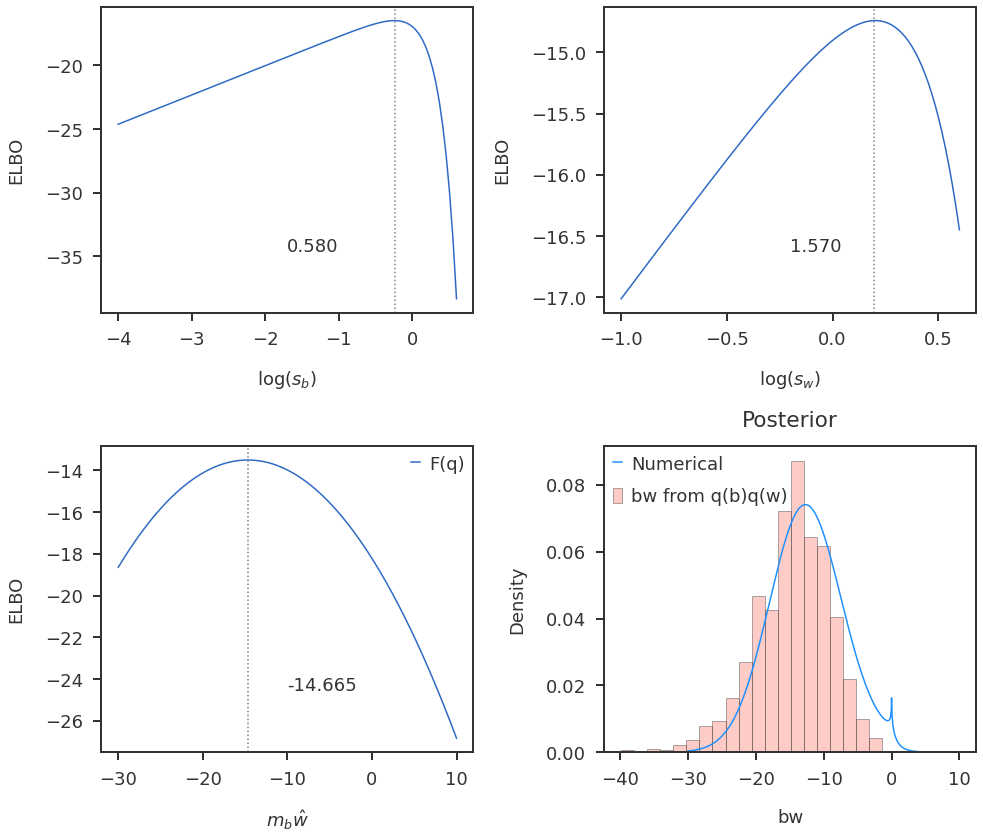

In [66]:
#collapse-hide

fig = plt.figure(figsize = (14, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

sbvals = np.logspace(-4, 0.6, 100)
elbo_sb = get_elbo_sb(X, y, sigtrue, sigbtrue, sigwtrue, btrue, wtrue, sbvals, sigwtrue)
elbo_sbopt = sbvals[np.argmax(elbo_sb)]
ax1.plot(np.log10(sbvals), elbo_sb)
ax1.axvline(np.log10(elbo_sbopt), color = 'gray', linestyle = 'dotted')
ax1.text(0.5, 0.2, f"{elbo_sbopt:.3f}", transform = ax1.transAxes)
ax1.set_xlabel("$\log({s_b})$")
ax1.set_ylabel("ELBO")

swvals = np.logspace(-1, 0.6, 100)
elbo_sw = get_elbo_sw(X, y, sigtrue, sigbtrue, sigwtrue, btrue, wtrue, elbo_sbopt, swvals)
elbo_swopt = swvals[np.argmax(elbo_sw)]
ax2.plot(np.log10(swvals), elbo_sw)
ax2.axvline(np.log10(elbo_swopt), color = 'gray', linestyle = 'dotted')
ax2.text(0.5, 0.2, f"{elbo_swopt:.3f}", transform = ax2.transAxes)
ax2.set_xlabel("$\log({s_w})$")
ax2.set_ylabel("ELBO")

elbo_bw = get_elbo_bw(X, y, sigtrue, sigbtrue, sigwtrue, 
                      bwvals / wtrue, wtrue, elbo_sbopt, elbo_swopt)
elbo_bwopt = bwvals[np.argmax(elbo_bw)]
numerical_evidence = numerical_logll + np.log(numerical_prior) - numerical_logpost
ax3.plot(bwvals, elbo_bw, label = "F(q)")
#ax3.plot(bwvals, numerical_evidence, ls = 'dotted', label = "log p(y)")
ax3.axvline(elbo_bwopt, color = 'gray', linestyle = 'dotted')
ax3.text(0.5, 0.2, f"{elbo_bwopt:.3f}", transform = ax3.transAxes)
ax3.legend()
ax3.set_xlabel(r"$m_b \hat{w}$")
ax3.set_ylabel("ELBO")


# variational_posterior = get_qbw_bw(bwvals, elbo_bwopt / wtrue, wtrue, 
#                                    elbo_sbopt, elbo_swopt)
# variational_bwopt = bwvals[np.argmax(variational_posterior)]
variational_posterior = get_qbw_hist(elbo_bwopt / wtrue, wtrue, elbo_sbopt, elbo_swopt)
ax4.plot(bwvals, numerical_posterior, label = "Numerical", color = 'dodgerblue')
ax4.hist(variational_posterior, density = True, label = "bw from q(b)q(w)", color = 'salmon', alpha = 0.4)
#ax4.axvline(variational_bwopt, linestyle = 'dashed', color = 'salmon')
#ax4.axvline(numerical_bwopt, linestyle = 'dotted', color = 'dodgerblue')
#ax4.text(0.5, 0.5, f"{variational_bwopt:.3f}", transform = ax4.transAxes)
ax4.legend()
ax4.set_title("Posterior", pad = 20.0)
ax4.set_xlabel("bw")
ax4.set_ylabel("Density")

plt.tight_layout()
plt.show()

### Coordinate ascent update

Here, I obtain the variational parameters using coordinate ascent updates of $m_b$, $s_b$, $m_w$ and $s_w$, while the hyperparameters are fixed at their true values, $\sigma = 5.0$, $\sigma_b = 2.0$ and $\sigma_w = 4.0$.

In [67]:
# collapse-hide

def veb_ridge_step(xtx, xty, sigma2, sigmab2, mw, sw2):
    mw2 = mw * mw
    sb2inv = (1 / sigmab2) + (xtx * (mw2 + sw2) / sigma2)
    sb2 = 1 / sb2inv
    mb = sb2 * mw * xty / sigma2
    return mb, sb2
    
def veb1(X, y,
         tol = 1e-8, max_iter = 10000,
         init_sigma = 1.0, init_sigmab = 1.0, init_sigmaw = 1.0,
         init_mb = 1.0, init_mw = 1.0, 
         init_sb = 1.0, init_sw = 1.0
        ):

    xtx = np.sum(np.square(X))
    xty = np.dot(X, y)
    elbo_path = np.zeros(max_iter + 1)
    
    # Initialize hyperparameters
    sigma2  = init_sigma  * init_sigma
    sigmab2 = init_sigmab * init_sigmab
    sigmaw2 = init_sigmaw * init_sigmaw
    
    # Initialize variational parameters
    sb2 = init_sb * init_sb
    sw2 = init_sw * init_sw
    mb  = init_mb
    mw  = init_mw
    
    niter = 0
    elbo_path[0] = -np.inf
    for itn in range(1, max_iter + 1):
        '''
        Update
        '''
        mb, sb2 = veb_ridge_step(xtx, xty, sigma2, sigmab2, mw, sw2)
        mw, sw2 = veb_ridge_step(xtx, xty, sigma2, sigmaw2, mb, sb2)
        '''
        Convergence
        '''
        niter += 1
        elbo_path[itn] = get_elbo_sq(X, y, sigma2, sigmab2, sigmaw2, mb, mw, sb2, sw2)
        if elbo_path[itn] - elbo_path[itn - 1] < tol: break

    return mb, mw, np.sqrt(sb2), np.sqrt(sw2), niter, elbo_path[:niter + 1]

In [68]:
# collapse-hide

veb_res = veb1(X, y, init_sigma = sigtrue, init_sigmab = sigbtrue, init_sigmaw = sigwtrue)

print(f"Optimized in {veb_res[4]} iterations. Final ELBO: {veb_res[5][-1]:.3f}")
print("Optimum parameters:")
print(f"mb = {veb_res[0]:.3f}")
print(f"mw = {veb_res[1]:.3f}")
print(f"sb = {veb_res[2]:.3f}")
print(f"sw = {veb_res[3]:.3f}")
print("")
print(f"bw = {veb_res[0] * veb_res[1]:.3f}")

Optimized in 12 iterations. Final ELBO: -12.821
Optimum parameters:
mb = -2.459
mw = 4.918
sb = 0.883
sw = 1.765

bw = -12.093


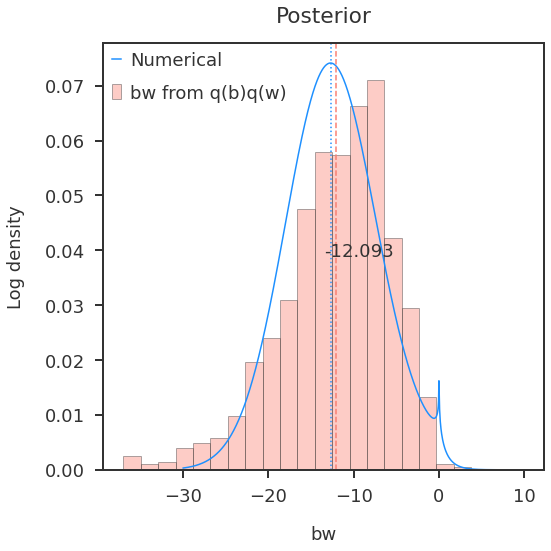

In [69]:
#collapse-hide

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

veb_posterior = get_qbw_hist(veb_res[0], veb_res[1], veb_res[2], veb_res[3])
veb_bwopt = veb_res[0] * veb_res[1]

ax1.plot(bwvals, numerical_posterior, label = "Numerical", color = 'dodgerblue')
ax1.axvline(numerical_bwopt, linestyle = 'dotted', color = 'dodgerblue')

ax1.hist(veb_posterior, density = True, label = "bw from q(b)q(w)", color = 'salmon', alpha = 0.4)
ax1.axvline(veb_bwopt, linestyle = 'dashed', color = 'salmon')

ax1.text(0.5, 0.5, f"{veb_bwopt:.3f}", transform = ax1.transAxes)
ax1.legend()
ax1.set_title("Posterior", pad = 20.0)
ax1.set_xlabel("bw")
ax1.set_ylabel("Log density")

plt.tight_layout()
plt.show()